# TNEG Geospatial Visualizations

This notebook contains a base map with county-level breakdown for the state of TN.  

The non-geospatial data that is read in here is generated by the dq3-TNEG-geospatial-data-preparation notebook.

In [100]:
# import statements
import pandas as pd
import numpy as np
import requests
import ipywidgets as widgets
#from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
#import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import json
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.models.widgets import DataTable
from bokeh.plotting import figure
from bokeh.palettes import brewer
import panel as pn
import panel.widgets as pnw
#import seaborn as sns
from io import StringIO
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from cartopy.io import shapereader
%matplotlib inline
# import io
# import scipy.stats as stats
# import statsmodels.api as sm

In [101]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Create a base map for the state of TN, broken down by county.

In [102]:
# Create a folium map, but probably not the best idea to subsequently join all of the other data
# tn_map = folium.Map(location=[36,-86], zoom_start = 7)
# tn_map

In [103]:
# Create a base map by importing the base shape file for TN census map
# Annoyingly, this is broken down by census division, not by county
# tn_census_map = gpd.read_file('../data/2018-TN-basemap/tl_2016_47_cousub.shp')
# tn_census_map.info()

In [104]:
# Check to see if COUNTYFP |is the right level to aggregate at to get county-level geometries
# tn_census_map['COUNTYFP'].nunique()

In [105]:
# Attempt to aggregate geometries by county - and not succeed
# tn_census_map.groupby('COUNTYFP')['geometry']

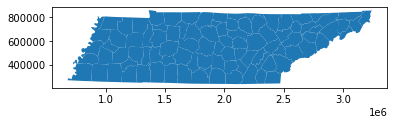

In [106]:
# Ask Michael, get this county-level base map shapefile instead
tn_county_map = gpd.read_file('../data/TN-county-basemap/tncounty.shp')
# See what the map looks like
tn_county_map.plot();

In [107]:
# Take a look at the base map dataframe
tn_county_map.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [108]:
# Check to make sure nothing is missing
tn_county_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95 non-null     int64   
 1   NAME        95 non-null     object  
 2   KEY         95 non-null     object  
 3   SHAPE_AREA  95 non-null     float64 
 4   SHAPE_LEN   95 non-null     float64 
 5   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.6+ KB


In [109]:
# check the projection type
tn_county_map.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [110]:
# change the projection type
tn_county_map = tn_county_map.to_crs('EPSG:4326')
print(tn_county_map.crs)
# Clean up some of the columns we don't need
tn_county_map = tn_county_map.drop(['OBJECTID', 'KEY', 'SHAPE_LEN'], axis = 1)
# Reformat column headers
tn_county_map.columns = ['county', 'shape_area', 'geometry']
# Set the county names to lower case
tn_county_map['county'] = tn_county_map['county'].str.lower()
# Make sure the base map dataset is good to go
tn_county_map.head(2)

EPSG:4326


,county,shape_area,geometry
0,chester,8.049024e+09,"POLYGON ((-88.78177 35.24759, -88.78185 35.247..."
1,wayne,2.050741e+10,"POLYGON ((-88.02474 35.39231, -88.02237 35.390..."


### Read in the non-spatial, county-level aggregations

In [112]:
tn_data = pd.read_csv('../data/TN_aggregated_data.csv')
tn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        95 non-null     int64  
 1   county                            95 non-null     object 
 2   pct_children_under_18             95 non-null     float64
 3   pct_people_living_in_rural_areas  95 non-null     float64
 4   pct_people_of_color               95 non-null     float64
 5   pct_people_with_disabilities      95 non-null     float64
 6   pct_senior_citizens               95 non-null     float64
 7   total_housing_units_2019          95 non-null     int64  
 8   county_full                       95 non-null     object 
 9   population_est                    95 non-null     int64  
 10  pct_insured                       95 non-null     float64
 11  race_afam                         95 non-null     int64  
 12  race_asam 

### Merge the non-spatial aggregate dataframe to the base map

In [113]:
# Join in the demographic data to the TN base map
tn_data_map = tn_county_map.merge(tn_data, on = 'county')
# Check to make sure it is a full join
tn_data_map

,county,shape_area,geometry,Unnamed: 0,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens,total_housing_units_2019,county_full,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up,area_miles2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability,pct_uninsured,gdp_2018,gdp_per_cap_2018,mag_mean,mag_median,mag_max,depth_mean,depth_median,depth_min,num_earthquakes,pct_prob_100y_median,pct_prob_100y_max
0,chester,8.049024e+09,"POLYGON ((-88.78177 35.24759, -88.78185 35.247...",11,23.3,65.24,10.6,15.6,14.6,7170,"Chester County, Tennessee",16949,88.0,1745,86,170,7,0,14541,141,402,2373,14576,1449,4317,3049,1785,6366,498,15917,2951,874,8583,3509,285.736117,0.6596,0.4255,0.5106,0.3298,0.5213,12.0,371878.0,21.940999,2.000000,2.000,2.00,5.000000,5.000,5.00,1.0,28.435,31.48
1,wayne,2.050741e+10,"POLYGON ((-88.02474 35.39231, -88.02237 35.390...",90,19.6,100.00,8.5,20.1,15.9,7366,"Wayne County, Tennessee",14606,88.8,378,64,284,43,0,13784,15,43,3030,11576,1908,4460,2561,1291,5308,382,14553,2853,1341,7393,2966,734.108826,0.7979,0.1915,0.2979,1.0000,0.8298,11.2,337678.0,23.119129,2.205000,2.205,2.40,4.135000,4.135,1.53,2.0,19.150,23.05
2,tipton,1.319125e+10,"MULTIPOLYGON (((-89.62931 35.37836, -89.62944 ...",83,27.2,55.13,20.7,15.5,11.1,24104,"Tipton County, Tennessee",60558,90.6,10832,469,1594,230,94,46116,255,1326,9672,50886,4975,15101,12280,6634,25641,1907,60391,8432,4299,27230,20430,458.403998,0.2234,0.6064,0.6809,0.0638,0.1702,9.4,1172035.0,19.353925,1.939545,1.835,3.20,8.860000,9.900,2.60,22.0,42.450,45.99
3,hamilton,1.604776e+10,"POLYGON ((-84.97698 34.98767, -84.97986 34.987...",32,21.6,10.02,23.7,14.5,14.7,165494,"Hamilton County, Tennessee",353438,91.0,68528,7218,19384,583,147,251820,3164,7310,49895,303543,25380,66405,73395,76178,157068,8872,346362,47360,25001,147921,126080,542.339868,0.0745,0.0106,0.9362,0.7021,0.2021,9.0,26341437.0,74.529159,1.999286,2.060,3.00,12.300000,11.260,0.11,28.0,18.850,27.20
4,stewart,1.375003e+10,"POLYGON ((-87.99034 36.36078, -87.99044 36.360...",80,22.9,100.00,5.0,20.4,16.7,6896,"Stewart County, Tennessee",13087,90.0,150,99,359,61,50,12049,65,359,2730,10357,1321,3919,2599,1332,4855,384,13024,2159,946,6563,3356,459.775870,0.4043,0.5319,0.2021,0.0319,0.1170,10.0,919563.0,70.265378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.980,29.79
5,robertson,1.328462e+10,"POLYGON ((-87.12044 36.45546, -87.12026 36.456...",73,25.7,53.24,11.5,12.6,11.8,28034,"Robertson County, Tennessee",68433,91.0,4618,378,4653,218,48,57409,1189,1611,10037,58396,5528,17710,13516,8538,31127,1804,68281,7923,4995,31185,24178,476.314061,0.1383,0.4149,0.9043,0.1489,0.2340,9.0,2368047.0,34.603875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.900,24.34
6,sumner,1.514543e+10,"POLYGON ((-86.75480 36.40545, -86.75373 36.405...",82,25.3,27.88,9.7,11.5,12.6,75354,"Sumner County, Tennessee",177908,91.3,12504,2282,8363,586,217,150848,2394,3834,24836,153072,11798,37006,37932,32252,82320,3174,177361,16833,9979,80275,70274,529.403390,0.0213,0.2128,0.7979,0.0745,0.0638,8.7,6706911.0,37.698760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.750,20.82
7,fentress,1.391048e+10,"POLYGON ((-85.11963 36.14466, -85.11958 36.144...",24,23.1,100.00,1.6,24.6,17.0,9063,"Fentress County, Tennessee",17818,90.3,0,108,269,32,0,17244,53,165,4268,13550,2453,5523,2697,1713,6042,450,17680,3855,2471,8176,3178,498.611086,0.8617,0.8191,0.0213,0.4149,0.6383,9.7,460492.0,25.844202,2.500000,2.500,2.50,20.600000,20.600,20.60,1.0,13.930,20.11
8,overton,1.212162e+10,"POLYGON ((-85.32358 36.20400, -85.32359 36.204...",66,23.2,84.22,1.9,18.7,16.8,10392,"Overton County, Tennessee",21723,91.3,104,104,298,0,75,20934,7,206,3436,18287,304

In [114]:
# Check to make sure nothing got dropped along the way
tn_data_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   county                            95 non-null     object  
 1   shape_area                        95 non-null     float64 
 2   geometry                          95 non-null     geometry
 3   Unnamed: 0                        95 non-null     int64   
 4   pct_children_under_18             95 non-null     float64 
 5   pct_people_living_in_rural_areas  95 non-null     float64 
 6   pct_people_of_color               95 non-null     float64 
 7   pct_people_with_disabilities      95 non-null     float64 
 8   pct_senior_citizens               95 non-null     float64 
 9   total_housing_units_2019          95 non-null     int64   
 10  county_full                       95 non-null     object  
 11  population_est                    95 non-null     in

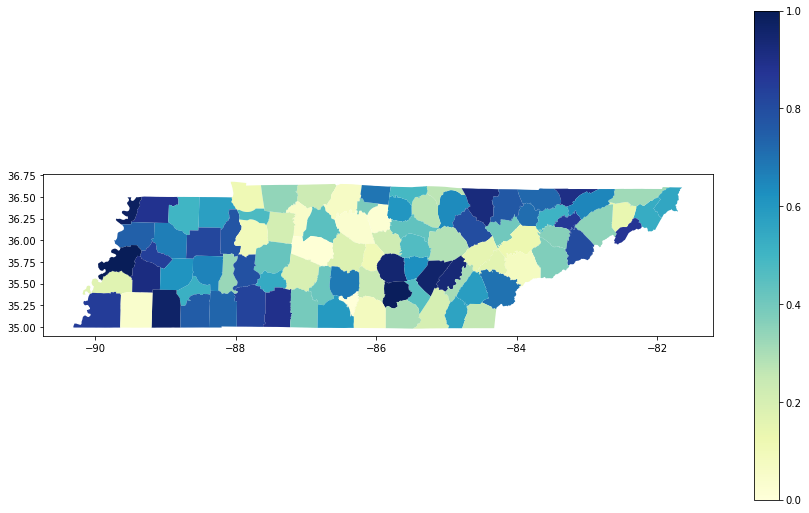

In [115]:
# Start exploring the data visually
ax = tn_data_map.plot(column='total_vulnerability', cmap =    
                                'YlGnBu', figsize=(15,9),   
                                 legend = True)

In [116]:
# Be lazy, get all of the columns so I don't have to type them out
tn_data_map.columns

Index(['county', 'shape_area', 'geometry', 'Unnamed: 0', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens', 'total_housing_units_2019', 'county_full', 'population_est', 'pct_insured', 'race_afam', 'race_asam', 'race_latn', 'race_natam', 'race_paci', 'race_white', 'race_othr', 'race_multi', 'disability_y', 'disability_n', 'edu_lessHS', 'edu_HSgrad', 'edu_assoc', 'edu_min_bac', 'employed_est', 'unemployed_est', 'tot_w_poverty_lvl_data', 'tot_poverty_less100', 'tot_poverty_101_138', 'tot_poverty_138_399', 'tot_poverty_400_up', 'area_miles2', 'socioeconomic', 'household_comp_and_disability', 'minority_status_and_language', 'housing_type_and_transportation', 'total_vulnerability', 'pct_uninsured', 'gdp_2018', 'gdp_per_cap_2018', 'mag_mean', 'mag_median', 'mag_max', 'depth_mean', 'depth_median', 'depth_min', 'num_earthquakes', 'pct_prob_100y_median', 'pct_prob_100y_max'], dtype='object')

In [119]:
# Build a widget to click through the choropleths based on each of the columns above
@widgets.interact(
    column = ['pct_children_under_18', 'pct_people_living_in_rural_areas', \
              'pct_people_of_color', 'pct_people_with_disabilities', \
              'pct_senior_citizens', 'total_housing_units_2019', 'county_full', \
              'population_est', 'pct_insured', 'race_afam', 'race_asam', \
              'race_latn', 'race_natam', 'race_paci', 'race_white', 'race_othr', \
              'race_multi', 'disability_y', 'disability_n', 'edu_lessHS', \
              'edu_HSgrad', 'edu_assoc', 'edu_min_bac', 'employed_est', \
              'unemployed_est', 'tot_w_poverty_lvl_data', 'tot_poverty_less100', \
              'tot_poverty_101_138', 'tot_poverty_138_399', 'tot_poverty_400_up', \
              'area_miles2', 'socioeconomic', 'household_comp_and_disability', \
              'minority_status_and_language', 'housing_type_and_transportation', \
              'total_vulnerability', 'pct_uninsured', 'gdp_2018', 'gdp_per_cap_2018', \
              'mag_mean', 'mag_median', 'mag_max', 'depth_mean', 'depth_median', \
              'depth_min', 'num_earthquakes', 'pct_prob_100y_median', 'pct_prob_100y_max'])

def throw_some_shade(column):
    """
    Change the choropleth based on the column value
    """
    ax = tn_data_map.plot(column=column, cmap =    
                                'YlGnBu', figsize=(30,9),   
                                 legend = True)
    plt.axis('off')

#widgets.interact(throw_some_shade, col=['total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas']);

interactive(children=(Dropdown(description='column', options=('pct_children_under_18', 'pct_people_living_in_r…

### Add the USGS earthquakes since 1900 to the enriched TN base map

In [122]:
# Join the USGS data to the enriched TN basemap
tn_earthquakes = gpd.sjoin(usgs_geo, tn_data_map, op = 'within')
tn_earthquakes

,time,latitude,longitude,depth,mag,magType,place,type,geometry,index_right,county,shape_area,Unnamed: 0,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens,total_housing_units_2019,county_full,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up,area_miles2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability,pct_uninsured,gdp_2018,gdp_per_cap_2018,mag_mean,mag_median,mag_max,depth_mean,depth_median,depth_min,num_earthquakes,pct_prob_100y_median,pct_prob_100y_max
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,"7 km NW of Ridgely, Tennessee",earthquake,POINT (-89.53617 36.31367),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787,10.2,210981.0,43.672325,1.530109,1.50,3.3,6.815432,6.77,0.0,2118.0,60.610,61.42
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,"3 km W of Ridgely, Tennessee",earthquake,POINT (-89.52333 36.26750),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787,10.2,210981.0,43.672325,1.530109,1.50,3.3,6.815432,6.77,0.0,2118.0,60.610,61.42
6,2020-10-19T20:31:16.660Z,36.419667,-89.499000,7.78,1.30,md,"5 km NNW of Tiptonville, Tennessee",earthquake,POINT (-89.49900 36.41967),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787,10.2,210981.0,43.672325,1.530109,1.50,3.3,6.815432,6.77,0.0,2118.0,60.610,61.42
16,2020-10-12T11:33:20.900Z,36.345000,-89.516667,5.33,1.33,md,"5 km SW of Tiptonville, Tennessee",earthquake,POINT (-89.51667 36.34500),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787,10.2,210981.0,43.672325,1.530109,1.50,3.3,6.815432,6.77,0.0,2118.0,60.610,61.42
17,2020-10-12T05:37:13.920Z,36.297167,-89.535667,10.26,1.45,md,"5 km NW of Ridgely, Tennessee",earthquake,POINT (-89.53567 36.29717),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787,10.2,210981.0,43.672325,1.530109,1.50,3.3,6.815432,6.77,0.0,2118.0,60.610,61.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7442,1984-06-17T17:05:47.900Z,35.390000,-88.780000,5.00,2.00,md,"13km WSW of Henderson, Tennessee",earthquake,POINT (-88.78000 35.39000),0,chester,8.049024e+09,11,23.3,65.24,10.6,15.6,14.6,7170,"Chester County, Tennessee",16949,88.0,1745,86,170,7,0,14541,141,402,2373,14576,1449,4317,3049,1785,6366,498,15917,2951,874,8583,3509,285.736117,0.6596,0.4255,0.5106,0.3298,0.5213,12.0,371878.0,21.940999,2.000000,2.00,2.0,5.000000,5.00,5.0,1.0,28.435,31.48
7491,1984-01-17T02:36:13.540Z,35.435000,-88.087000,8.10,2.20,md,"9km WNW of Clifton, Tennessee",earthquake,POINT (-88.08700 35.43500),52,decatur,9.615720e+09,19,21.5,100.00,4.8,22.1,20.7,6931,"Decatur County, Tennessee",11443,91.6,396,47,198,0,0,

In [126]:
# Remove non-earthquake data
tn_earthquakes = tn_earthquakes[tn_earthquakes['type'] == 'earthquake']
# Cleanup an unnecessary column
tn_earthquakes = tn_earthquakes.drop(['index_right'], axis = 1)
tn_earthquakes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4270 entries, 3 to 7637
Data columns (total 60 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   time                              4270 non-null   object  
 1   latitude                          4270 non-null   float64 
 2   longitude                         4270 non-null   float64 
 3   depth                             4266 non-null   float64 
 4   mag                               4268 non-null   float64 
 5   magType                           4262 non-null   object  
 6   place                             4270 non-null   object  
 7   type                              4270 non-null   object  
 8   geometry                          4270 non-null   geometry
 9   county                            4270 non-null   object  
 10  shape_area                        4270 non-null   float64 
 11  Unnamed: 0                        4270 non-null 

### Visualize some earthquakes and stuff

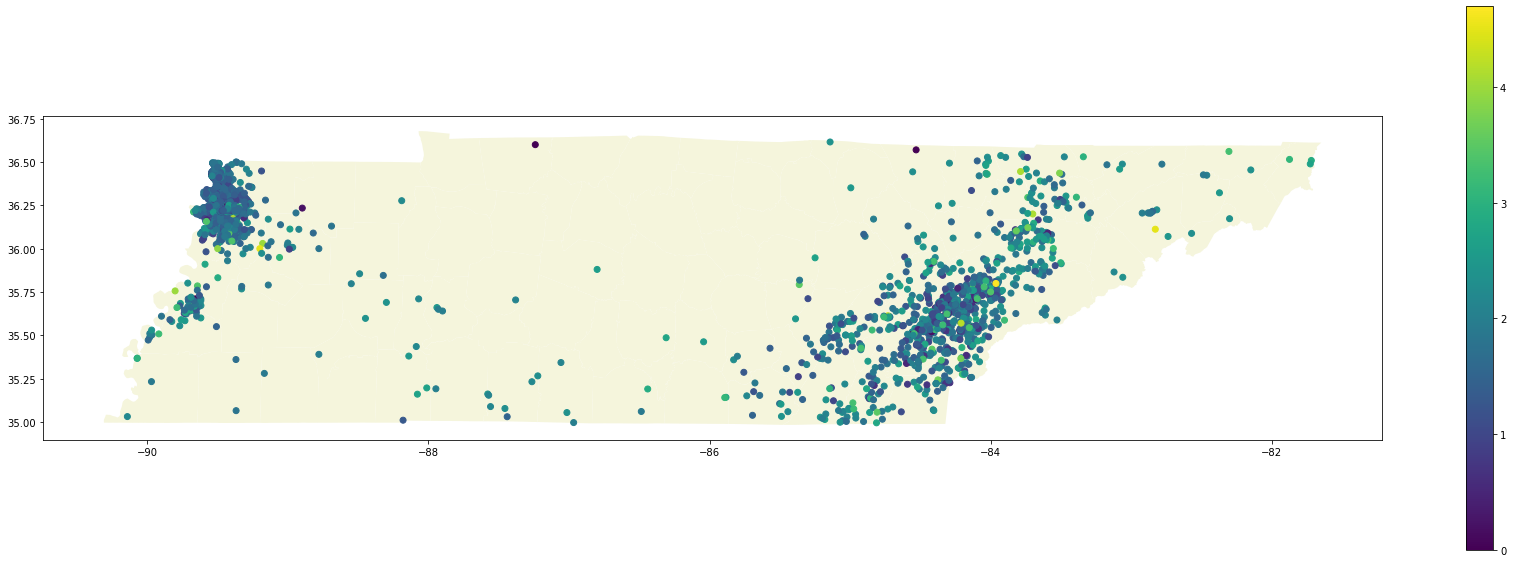

In [127]:
# map the earthquakes, color-coded by magnitute
ax = tn_county_map.plot(figsize = (30, 10), color = 'beige')
tn_earthquakes.plot( ax = ax, column = 'mag', legend = True)
plt.show();

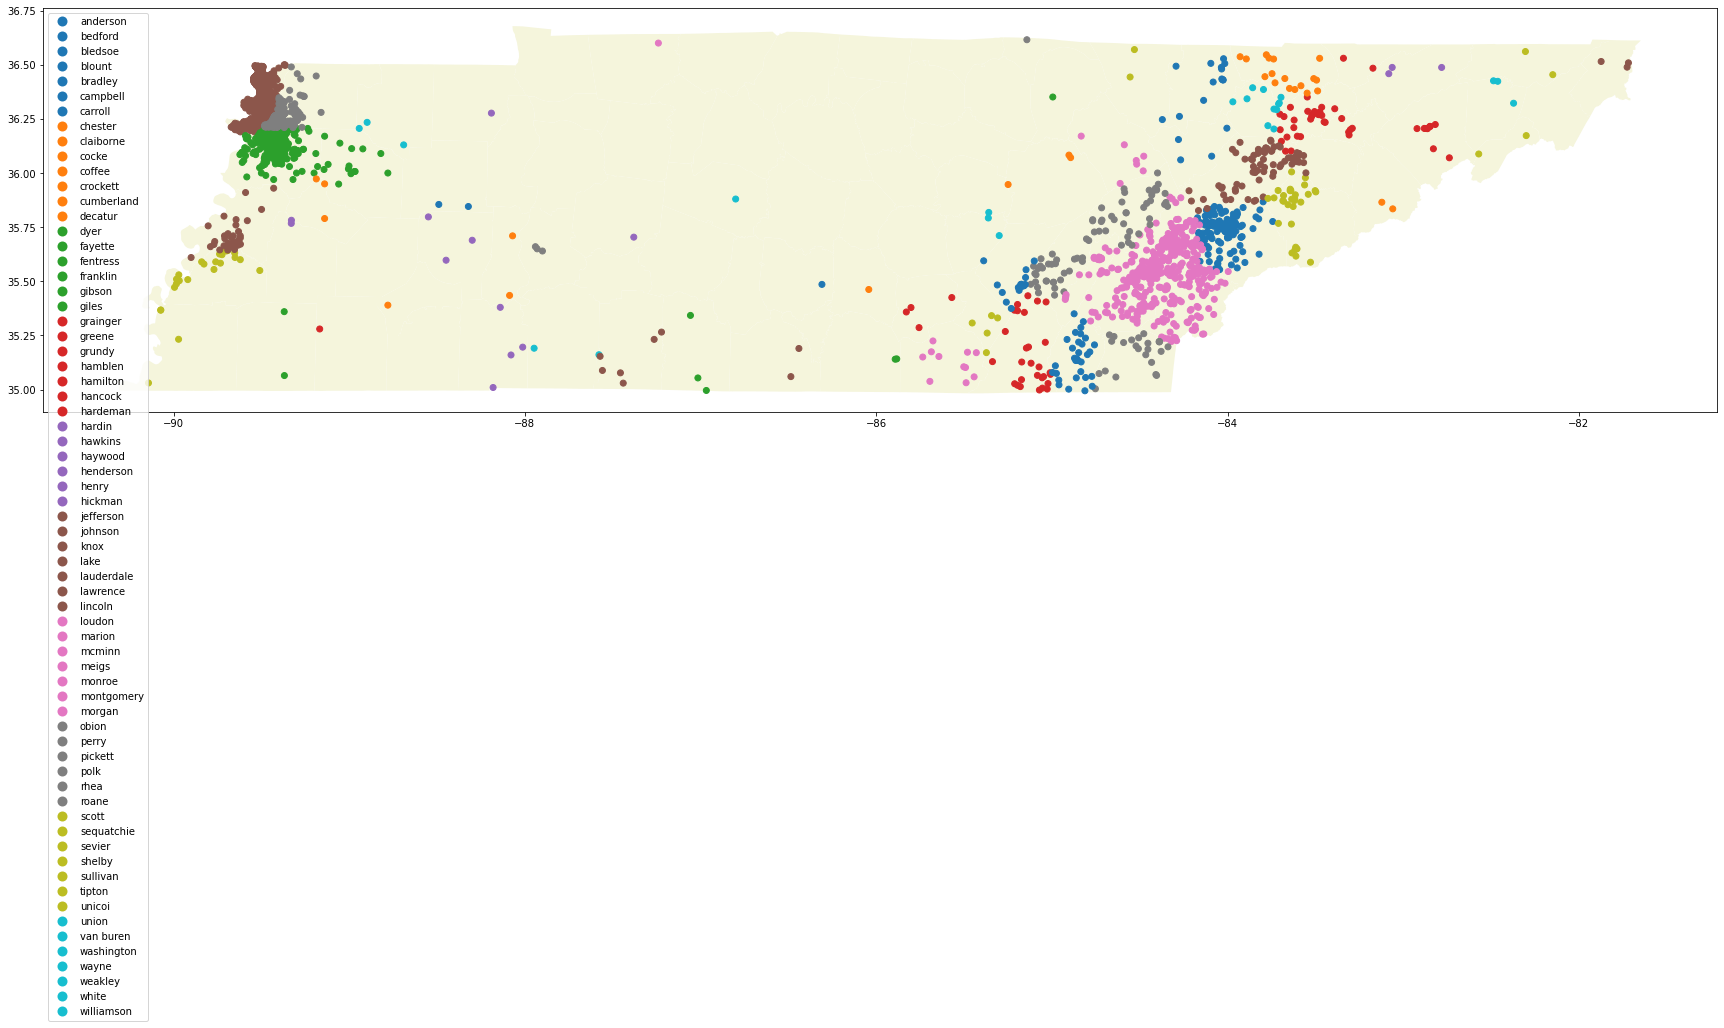

In [128]:
# map the earthquakes, color-coded by county
# not especially useful
ax = tn_county_map.plot(figsize = (30, 10), color = 'beige')
tn_earthquakes.plot( ax = ax, column = 'county', legend = True)
plt.show();

In [129]:
# Since 1900, how many earthquakes per county?
tn_earthquakes['county'].value_counts()

lake          2118
dyer           644
obion          391
monroe         210
blount         135
loudon         100
mcminn          91
knox            59
lauderdale      40
rhea            38
bradley         36
roane           35
sevier          30
grainger        29
meigs           28
hamilton        28
polk            24
tipton          22
bledsoe         18
claiborne       17
campbell        14
jefferson       14
gibson          14
marion          11
union           11
greene          10
morgan           7
lawrence         6
hamblen          5
sequatchie       5
grundy           4
hardin           4
shelby           4
anderson         4
henderson        3
perry            3
cumberland       3
weakley          3
hawkins          3
crockett         3
johnson          3
washington       3
giles            3
van buren        2
franklin         2
scott            2
fayette          2
unicoi           2
carroll          2
decatur          2
cocke            2
wayne            2
sullivan    

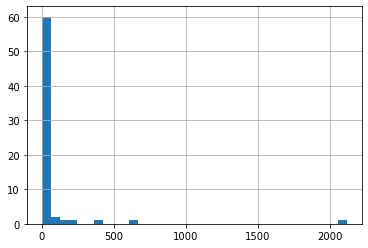

In [130]:
tn_earthquakes['county'].value_counts().hist(bins = 35);

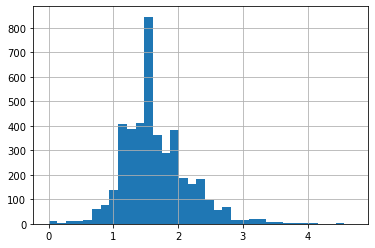

In [131]:
tn_earthquakes['mag'].hist(bins = 35);

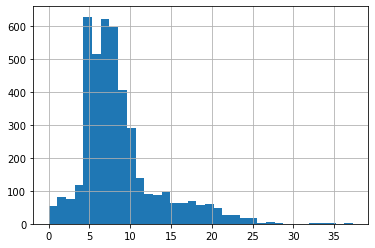

In [132]:
tn_earthquakes['depth'].hist(bins = 35);